In [1]:
# Since early 2014, I have been in the business of "discovering" new music. For the past 6, almost 7 years now,
# I have been actively seeking out and exploring various genres and music of all kinds. Whether it's the biggest
# popstar in Taylor Swift or my favorite indie artist in Meg Myers, my ears have been listening to the newest 
# (and sometimes oldest) bops. 

# Throughout the years though, I have always wondered which songs I favored more than others. Unfortunately, Spotify, my 
# music listening platform of choice, doesn't actively display these results. So in order to get a better grasp of my
# listening habits, I signed up for the platform Last.FM in late 2018. This site tracks all of my music listening history
# across multiple sites including Spotify, Apple Music, Youtube, etc., but I have been mostly using it to track my Spotify
# history. It has allowed me see my most played songs (in 2019 it was "Moral of the Story" by Ashe with 88 scrobbles), my 
# favorite genres (Indie, Rock, Alternative), and even others who have similar musical interests.

# However, Last.FM is limited in what it will display, but if you have some programming skills, Last.FM's API allows you
# to take an even deeper dive into your listening habits.

# That being said, I was curious to see if I could predict my future listening habits to a newly discovered song. For example,
# Meg Myers recently released the song "Any Way You Wanna Love." Is it possible to predict how many times I would listen to
# this single in the next month based on only a few weeks' playcounts? What about the next year? 
# Well, this project aims to answer this.

In [2]:
# Import packages
import json
import requests
import requests_cache
import time
from IPython.core.display import clear_output
import pandas as pd
from datetime import datetime
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

In [3]:
# Write a function to query the Last.FM API. We are using their built in user.getWeeklyTrackChart method to pull in 
# my account's listening history
def lastfm_get(payload):
    headers = {'user-agent': 'suosuosuo'}           #my last.fm account name
    url = 'http://ws.audioscrobbler.com/2.0/'

    # Add API key and format to the payload
    payload['user'] = 'suosuosuo'
    payload['api_key'] = '68092ef6b53c85c60bff9638923ac3cc'
    payload['format'] = 'json'

    response = requests.get(url, headers=headers, params=payload)
    return response

In [4]:
# Test the connection
r = lastfm_get({
    'method': 'user.getWeeklyTrackChart'
})

# A 200 means we successfully called the API
r.status_code

200

In [5]:
# Now that we can call the API, we need to build our dataset.
responses = []

# We are looking at how new songs perform for 1 year in terms of playcount so we will have to extract 52 weeks worth of data. 
# In order to simplify this, we need an discovery period and a collection period. 
# Today is 11/21/2020. In order for each song to have 1 year's worth of data,
# we are first going to see what songs were listened to from 1/3/19 to 11/21/19 (46 full weeks) (discovery period).
# The collection period will then be from 11/21/19 to 11/19/20 (52 full weeks)
week = 1
total_weeks = 98  #46 + 52                                         

# As this project is about music discovery, each week will start on Thursday at 9pm PT.
# This is because that's the time when new music is released each week.
ts = datetime(2019, 1, 4, 5)                                       # 1/4/19 5am UTC --- 1/3/19 9pm PT. 
start = int((ts - datetime(1970,1,1)).total_seconds())             # Convert date to unix
end = start + 604800                                               # 60s * 60m * 24h * 7d = 604800 seconds in one week

# For each week, collect the user's tracks played
for week in range(1, total_weeks + 1): 
    payload = {
        'method': 'user.getWeeklyTrackChart',
        'user': 'suosuosuo',
        'from': start,
        'to': end
    }

    print("Requesting week {}/{}".format(week, total_weeks))       # Print status
    clear_output(wait = True)                                      # Clear the output to make things neater

    response = lastfm_get(payload)                                 # API call
    
    responses.append(response)                                     # Append response

    if not getattr(response, 'from_cache', False):                 # If it's not a cached result, sleep to avoid overcalling API
        time.sleep(0.25)
    
    start = end                                                    # Move the start to the next week
    end = end + 604800                                             # Move the end to the next week

Requesting week 98/98


In [6]:
# The data is not exactly how we want it, so let's create the bones for a new dataframe 
dat = pd.DataFrame()
dat['song'] = []
dat['artist'] = []
dat['playcount'] = []
dat['week'] = []

# Data sample for the first week
#r0 = responses[35]
#r0_json = r0.json()
#r0_tracks = r0_json['weeklytrackchart']['track']
#r0_df = pd.DataFrame(r0_tracks)
#r0_df

In [7]:
week = 1
total_weeks = 98

# We need to clean up the data for each week sampled
for week in range(1, total_weeks + 1):
    rweek = responses[week - 1]                                   # Start at entry 0, or week 1
    rjson = rweek.json()                                          # Convert the data to json
    rweek_tracks = rjson['weeklytrackchart']['track']             # Select the necessary data
    rweek_df = pd.DataFrame(rweek_tracks)                         # Add it to a dataframe
    
    tracks = len(rweek_df)                                        # How many unique songs were played this week? Needed below
    
    print("Updating week {}/{}".format(week, total_weeks))        # Print status
    clear_output(wait = True)                                     # Clear the output to make things neater
    
    # We are in a specific week. Each song in each week needs to be cleaned up and restructured as well
    for tracks in range(1, tracks+ 1):
        song = rweek_df['name'][tracks - 1]
        artist = rweek_df['artist'][tracks - 1]['#text']
        playcount = rweek_df['playcount'][tracks - 1]
        dat = dat.append({'song' : song,
                                        'artist' : artist,
                                        'playcount': playcount,
                                        'week': week}, ignore_index = True) 
# Occasionally this returns an error. This is a Last.FM issue
# 'error': 8, 'message': 'Operation failed - Most likely the backend service failed. Please try again.'
# I have had success by simply re-running the previous 2 blocks (re-calling the API) and this should run properly afterwards

Updating week 98/98


In [8]:
dat.head()

,song,artist,playcount,week
0,Stuck,The Aces,6,1.0
1,Alone in a Room,Asking Alexandria,3,1.0
2,Lemon Glow,Beach House,3,1.0
3,Cry!,Caroline Rose,3,1.0
4,Jeannie Becomes a Mom,Caroline Rose,3,1.0


In [9]:
# Convert the song and artist to a single variable
dat['track'] = dat['song'] + ' by ' + dat['artist']
cols = list(dat)

# Move Track to the first column
cols.insert(0, cols.pop(cols.index('track')))

# Reorder the columns again
dat = dat.loc[:, cols]
dat = dat.drop('song', axis=1)
dat = dat.drop('artist', axis=1)
dat.head()

,track,playcount,week
0,Stuck by The Aces,6,1.0
1,Alone in a Room by Asking Alexandria,3,1.0
2,Lemon Glow by Beach House,3,1.0
3,Cry! by Caroline Rose,3,1.0
4,Jeannie Becomes a Mom by Caroline Rose,3,1.0


In [10]:
# Save this dataset so we don't have to call the API anymore
dat.to_csv('dat_alltracks.csv',index=False)

In [11]:
# Load the dataset if needed
dat = pd.read_csv('dat_alltracks.csv')

In [12]:
# Let's add 3 new variables to help us out later
dat['playcount'] = pd.to_numeric(dat['playcount'])
dat['sum'] = dat.groupby('track')['playcount'].transform('sum')
dat['first_week'] = dat.groupby('track')['week'].transform('min')
dat['week_offset'] = dat['week'] - dat['first_week']

In [13]:
# We now have to trim down our data
# Let's use the song 'Believe by The Bravery' as an example

# First, we are only looking at songs whose first play is from first_week 1-46. This ensures we have at least 52 weeks of data
# for each song.

# Second, some songs that were first listened to early on may have playcounts from more than 52 weeks. Since we are predicting
# the playcount for one year, we must filter out songs whose week_offset is greater than 51 (week_offset starts at 0)

# Finally, we are only looking at 'new' songs. In other words, songs that I just discovered and listened to many times early on.

# Does the following song look 'new'? No. I actually started listening to this song before 2013. It just happens to play
# on occasion via shuffle mode. As we can see, I first played it during week 3 (out of 98) and during it's first 2 weeks
# (week_offset 0 and 1), it only had a total of 2 plays.


#I must filter out these 'old' songs. To do this, I will require that I listened to the song
# at least 5 times in the first two weeks of play.
dat[dat['track'] == 'Believe by The Bravery']

,track,playcount,week,sum,first_week,week_offset
1095,Believe by The Bravery,1,3.0,26,3.0,0.0
1933,Believe by The Bravery,1,4.0,26,3.0,1.0
2572,Believe by The Bravery,1,5.0,26,3.0,2.0
3072,Believe by The Bravery,1,6.0,26,3.0,3.0
4723,Believe by The Bravery,1,9.0,26,3.0,6.0
5738,Believe by The Bravery,1,11.0,26,3.0,8.0
8116,Believe by The Bravery,1,16.0,26,3.0,13.0
13125,Believe by The Bravery,1,26.0,26,3.0,23.0
15541,Believe by The Bravery,1,32.0,26,3.0,29.0
16768,Believe by The Bravery,3,36.0,26,3.0,33.0


In [14]:
# First, we are only looking at songs whose first play is from first_week 1-46. This ensures we have at least 52 weeks of data
# for each song.
dat = dat[dat['first_week'] <= 46]
dat

,track,playcount,week,sum,first_week,week_offset
0,Stuck by The Aces,6,1.0,44,1.0,0.0
1,Alone in a Room by Asking Alexandria,3,1.0,14,1.0,0.0
2,Lemon Glow by Beach House,3,1.0,21,1.0,0.0
3,Cry! by Caroline Rose,3,1.0,43,1.0,0.0
4,Jeannie Becomes a Mom by Caroline Rose,3,1.0,59,1.0,0.0
...,...,...,...,...,...,...
36584,Beverly Hills by Weezer,1,98.0,15,7.0,91.0
36585,Your Woman by White Town,1,98.0,25,3.0,95.0
36587,Carry On - Acoustic by Young Rising Sons,1,98.0,11,5.0,93.0
36589,Whiskey by Young Rising Sons,1,98.0,35,2.0,96.0


In [15]:
# Second, some songs that were first listened to early on may have playcounts from more than 52 weeks. Since we are predicting
# the playcount for one year, we must filter out songs whose week_offset is greater than 51 (week_offset starts at 0)
dat = dat[dat['week_offset'] <= 51]
dat

,track,playcount,week,sum,first_week,week_offset
0,Stuck by The Aces,6,1.0,44,1.0,0.0
1,Alone in a Room by Asking Alexandria,3,1.0,14,1.0,0.0
2,Lemon Glow by Beach House,3,1.0,21,1.0,0.0
3,Cry! by Caroline Rose,3,1.0,43,1.0,0.0
4,Jeannie Becomes a Mom by Caroline Rose,3,1.0,59,1.0,0.0
...,...,...,...,...,...,...
35118,You Sexy Thing by Zella Day,1,93.0,31,43.0,50.0
35254,Uh Huh by Jade Bird,1,94.0,22,44.0,50.0
36005,Lose Our Heads by Yonaka,3,97.0,43,46.0,51.0
36012,The Suburbs by Arcade Fire,2,97.0,18,46.0,51.0


In [16]:
# In order to find the number of plays in the first two weeks, let's rearrange the data.
dat2 = dat.drop('week', axis=1)
dat2 = dat2.drop('sum', axis=1)
dat2 = dat2.drop('first_week', axis=1)

dat2 = dat2.pivot_table(index=['track'], columns = 'week_offset', values = 'playcount', aggfunc = 'first').reset_index()
dat2 = dat2.fillna(0)
dat2

week_offset,track,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0
0,"""99"" by Barns Courtney",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""U"" (feat. Merges) by sergioisdead",1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,#30 - Ft. Scarra - Life as a Top League Of Leg...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,#Grownupz by Fein,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,#SELFIE by The Chainsmokers,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,when the party's over by Billie Eilish,6.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3819,whywhywhy by MisterWives,7.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3820,wish you were gay by Billie Eilish,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3821,youth by Vérité,5.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dat2.to_csv('dat2_wideweeks.csv',index=False)

In [ ]:
# For ease, open your new excel file and rename B2 = 'Week 1'. Drag this all the way to right, save, and close the file

In [24]:
dat3 = pd.read_csv('dat2_wideweeks.csv')

In [25]:
# To filter for new songs, count the number of plays in the first two weeks.
dat3['first_two_weeks_plays'] = dat3.iloc[:, 1:3].sum(axis=1)

In [26]:
dat3.head()

,track,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,...,Week 44,Week 45,Week 46,Week 47,Week 48,Week 49,Week 50,Week 51,Week 52,first_two_weeks_plays
0,"""99"" by Barns Courtney",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"""U"" (feat. Merges) by sergioisdead",1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,#30 - Ft. Scarra - Life as a Top League Of Leg...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,#Grownupz by Fein,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,#SELFIE by The Chainsmokers,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
dat3 = dat3[dat3['first_two_weeks_plays'] >= 5]
dat3 = dat3.drop('first_two_weeks_plays', axis=1)
dat3.head()

,track,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,...,Week 43,Week 44,Week 45,Week 46,Week 47,Week 48,Week 49,Week 50,Week 51,Week 52
12,...interlude... by Vérité,2,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,1950 by King Princess,7,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,2all by Catfish and the Bottlemen,5,6,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,99 Luftballons by Nena,5,3,2,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
69,A Thousand Ways (Acoustic) by Phoebe Ryan,1,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# We now have all the new songs from 1/3/19 to 11/21/19 with 52 weeks worth of data for each song! This amounts to 279 songs.

In [29]:
#Save the file
dat3.to_csv('dat3_newsongswide.csv',index=False)

In [30]:
#Load the file
dat4 = pd.read_csv('dat3_newsongswide.csv')

In [31]:
# Melt the data
dat4 = dat4.melt(id_vars=['track'], var_name='Week', value_name='Playcount')
dat4.to_csv('dat4_newsongmelt.csv',index=False)

In [32]:
dat4.head()

,track,Week,Playcount
0,...interlude... by Vérité,Week 1,2
1,1950 by King Princess,Week 1,7
2,2all by Catfish and the Bottlemen,Week 1,5
3,99 Luftballons by Nena,Week 1,5
4,A Thousand Ways (Acoustic) by Phoebe Ryan,Week 1,1


track
...interlude... by Vérité                    AxesSubplot(0.125,0.125;0.775x0.755)
1950 by King Princess                        AxesSubplot(0.125,0.125;0.775x0.755)
2all by Catfish and the Bottlemen            AxesSubplot(0.125,0.125;0.775x0.755)
99 Luftballons by Nena                       AxesSubplot(0.125,0.125;0.775x0.755)
A Thousand Ways (Acoustic) by Phoebe Ryan    AxesSubplot(0.125,0.125;0.775x0.755)
                                                             ...                 
think of me by Vérité                        AxesSubplot(0.125,0.125;0.775x0.755)
urs by Niki                                  AxesSubplot(0.125,0.125;0.775x0.755)
when the party's over by Billie Eilish       AxesSubplot(0.125,0.125;0.775x0.755)
whywhywhy by MisterWives                     AxesSubplot(0.125,0.125;0.775x0.755)
youth by Vérité                              AxesSubplot(0.125,0.125;0.775x0.755)
Length: 279, dtype: object

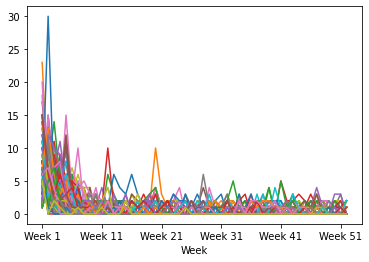

In [33]:
# Let's take a glance at a quick graph
fig, ax = plt.subplots()
dat4.groupby('track').plot(x='Week', y='Playcount', ax=ax, legend=False)

In [34]:
# As expected, song playcounts drop off significantly after a few weeks as they are repalced with new tracks.

In [36]:
# Let's see if plays in the first month has any predictive power
dat5 = dat3
dat5['month1_plays'] = dat5.iloc[:, 1:5].sum(axis=1)
dat5['month2_plays'] = dat5.iloc[:, 5:9].sum(axis=1)
dat5['month2_12_plays'] = dat5.iloc[:, 5:53].sum(axis=1)
dat5.head()

,track,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,...,Week 46,Week 47,Week 48,Week 49,Week 50,Week 51,Week 52,month1_plays,month2_plays,month2_12_plays
12,...interlude... by Vérité,2,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,3
27,1950 by King Princess,7,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,1
40,2all by Catfish and the Bottlemen,5,6,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,17,0,12
56,99 Luftballons by Nena,5,3,2,0,1,1,0,0,1,...,0,0,0,0,0,0,0,10,2,3
69,A Thousand Ways (Acoustic) by Phoebe Ryan,1,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,5,1,4


In [37]:
# Month 1 to predict Month 2
x = dat5['month1_plays']
y = dat5['month2_plays']

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.15574627332861077


In [38]:
# Month 1 to predict Month 2-11
x = dat5['month1_plays']
y = dat5['month2_12_plays']

correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.32914239877852813


In [39]:
# Both R^2 values are very low. Originally, I was hoping that there would be a quick and easy way to predict how many times
# I would listen to a song after one month's time. Based on these R^2 values, this is not the case. Maybe specific genres
# or artists behave diffrently, but overall a song's first month's playcounts can't predict a song's second month's playcounts
# or its playcounts for the rest of the year.

In [50]:
dat5.to_csv('dat5_cleaned.csv',index=False)
#dat5 = pd.read_csv('dat5_cleaned.csv')

In [40]:
# Now that our original question is answered, I wanted to display some additional graphics just to explore more of my
# music listening habits. (Some of these are displayed on Last.FM, but I wanted to see if I could reproduce their results
# with the same data since some of their features are locked behind a paywall)

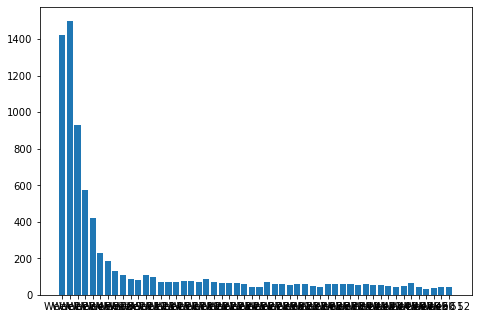

In [41]:
# New Songs - Total playcounts per week offset by week found
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
week = ['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8','Week 9','Week 10',
'Week 11','Week 12','Week 13','Week 14','Week 15','Week 16','Week 17','Week 18','Week 19','Week 20',
'Week 21','Week 22','Week 23','Week 24','Week 25','Week 26','Week 27','Week 28','Week 29','Week 30',
'Week 31','Week 32','Week 33','Week 34','Week 35','Week 36','Week 37','Week 38','Week 39','Week 40',
'Week 41','Week 42','Week 43','Week 44','Week 45','Week 46','Week 47','Week 48','Week 49','Week 50',
'Week 51','Week 52',
]
playcounts = [dat3['Week 1'].sum(),dat3['Week 2'].sum(),dat3['Week 3'].sum(),dat3['Week 4'].sum(),
dat3['Week 5'].sum(),dat3['Week 6'].sum(),dat3['Week 7'].sum(),dat3['Week 8'].sum(),
dat3['Week 9'].sum(),dat3['Week 10'].sum(),dat3['Week 11'].sum(),dat3['Week 12'].sum(),
dat3['Week 13'].sum(),dat3['Week 14'].sum(),dat3['Week 15'].sum(),dat3['Week 16'].sum(),
dat3['Week 17'].sum(),dat3['Week 18'].sum(),dat3['Week 19'].sum(),dat3['Week 20'].sum(),
dat3['Week 21'].sum(),dat3['Week 22'].sum(),dat3['Week 23'].sum(),dat3['Week 24'].sum(),
dat3['Week 25'].sum(),dat3['Week 26'].sum(),dat3['Week 27'].sum(),dat3['Week 28'].sum(),
dat3['Week 29'].sum(),dat3['Week 30'].sum(),dat3['Week 31'].sum(),dat3['Week 32'].sum(),
dat3['Week 33'].sum(),dat3['Week 34'].sum(),dat3['Week 35'].sum(),dat3['Week 36'].sum(),
dat3['Week 37'].sum(),dat3['Week 38'].sum(),dat3['Week 39'].sum(),dat3['Week 40'].sum(),
dat3['Week 41'].sum(),dat3['Week 42'].sum(),dat3['Week 43'].sum(),dat3['Week 44'].sum(),
dat3['Week 45'].sum(),dat3['Week 46'].sum(),dat3['Week 47'].sum(),dat3['Week 48'].sum(),
dat3['Week 49'].sum(),dat3['Week 50'].sum(),dat3['Week 51'].sum(),dat3['Week 52'].sum()]

ax.bar(week,playcounts)
plt.show()

In [42]:
# Songs are played most often the first and seconds weeks after they are discovered - which makes perfect sense. 
# It also makes sense that week 2 is slightly above week 1 since week 1 usually won't include 7 days worth of data.
# This is because each "week" is hardcoded from Thursday - Wednesday, not on when a song is first played.

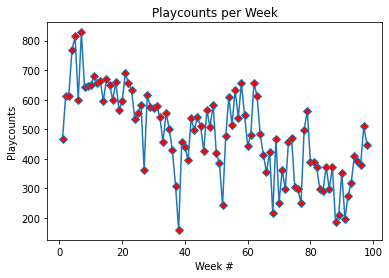

In [43]:
# Total song playcounts by week - all songs
dat8 = pd.read_csv('dat_alltracks.csv')

dat8 = dat8.pivot_table(index=['track'], columns = 'week', values = 'playcount').reset_index()
dat8 = dat8.fillna(0)


week = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,
13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,
29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,
45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,
61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,
77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,
93.0,94.0,95.0,96.0,97.0,98.0]

playcounts = [dat8[1.0].sum(),dat8[2.0].sum(),
dat8[3.0].sum(),dat8[4.0].sum(),dat8[5.0].sum(),dat8[6.0].sum(),
dat8[7.0].sum(),dat8[8.0].sum(),dat8[9.0].sum(),dat8[10.0].sum(),
dat8[11.0].sum(),dat8[12.0].sum(),dat8[13.0].sum(),dat8[14.0].sum(),
dat8[15.0].sum(),dat8[16.0].sum(),dat8[17.0].sum(),dat8[18.0].sum(),
dat8[19.0].sum(),dat8[20.0].sum(),dat8[21.0].sum(),dat8[22.0].sum(),
dat8[23.0].sum(),dat8[24.0].sum(),dat8[25.0].sum(),dat8[26.0].sum(),
dat8[27.0].sum(),dat8[28.0].sum(),dat8[29.0].sum(),dat8[30.0].sum(),
dat8[31.0].sum(),dat8[32.0].sum(),dat8[33.0].sum(),dat8[34.0].sum(),
dat8[35.0].sum(),dat8[36.0].sum(),dat8[37.0].sum(),dat8[38.0].sum(),
dat8[39.0].sum(),dat8[40.0].sum(),dat8[41.0].sum(),dat8[42.0].sum(),
dat8[43.0].sum(),dat8[44.0].sum(),dat8[45.0].sum(),dat8[46.0].sum(),
dat8[47.0].sum(),dat8[48.0].sum(),dat8[49.0].sum(),dat8[50.0].sum(),
dat8[51.0].sum(),dat8[52.0].sum(),dat8[53.0].sum(),dat8[54.0].sum(),
dat8[55.0].sum(),dat8[56.0].sum(),dat8[57.0].sum(),dat8[58.0].sum(),
dat8[59.0].sum(),dat8[60.0].sum(),dat8[61.0].sum(),dat8[62.0].sum(),
dat8[63.0].sum(),dat8[64.0].sum(),dat8[65.0].sum(),dat8[66.0].sum(),
dat8[67.0].sum(),dat8[68.0].sum(),dat8[69.0].sum(),dat8[70.0].sum(),
dat8[71.0].sum(),dat8[72.0].sum(),dat8[73.0].sum(),dat8[74.0].sum(),
dat8[75.0].sum(),dat8[76.0].sum(),dat8[77.0].sum(),dat8[78.0].sum(),
dat8[79.0].sum(),dat8[80.0].sum(),dat8[81.0].sum(),dat8[82.0].sum(),
dat8[83.0].sum(),dat8[84.0].sum(),dat8[85.0].sum(),dat8[86.0].sum(),
dat8[87.0].sum(),dat8[88.0].sum(),dat8[89.0].sum(),dat8[90.0].sum(),
dat8[91.0].sum(),dat8[92.0].sum(),dat8[93.0].sum(),dat8[94.0].sum(),
dat8[95.0].sum(),dat8[96.0].sum(),dat8[97.0].sum(),dat8[98.0].sum()]


plt.plot(week, playcounts, marker='D',mfc='red')
plt.title('Playcounts per Week')
plt.xlabel('Week #')
plt.ylabel('Playcounts')
plt.show()

In [44]:
# It seems like playcounts have decreased in 2020 (weeks 47-98). I have been inside more and don't listen to music as much 
# as I am no longer commuting or studying.

In [54]:
dat8.to_csv('dat8_total.csv',index=False)
#dat8 = pd.read_csv('dat8_total.csv')

In [55]:
# Here are my most played tracks in a single week over the past 98 weeks
dat9 = dat8.melt(id_vars=['track'], var_name='Week', value_name='Playcount')
idx = dat9.groupby(['Week'])['Playcount'].transform(max) == dat9['Playcount']
dat10 = dat9[idx]
dat10 = dat10[dat10['Playcount'] >= 15]
dat10 = dat10.sort_values('Playcount',ascending=False)

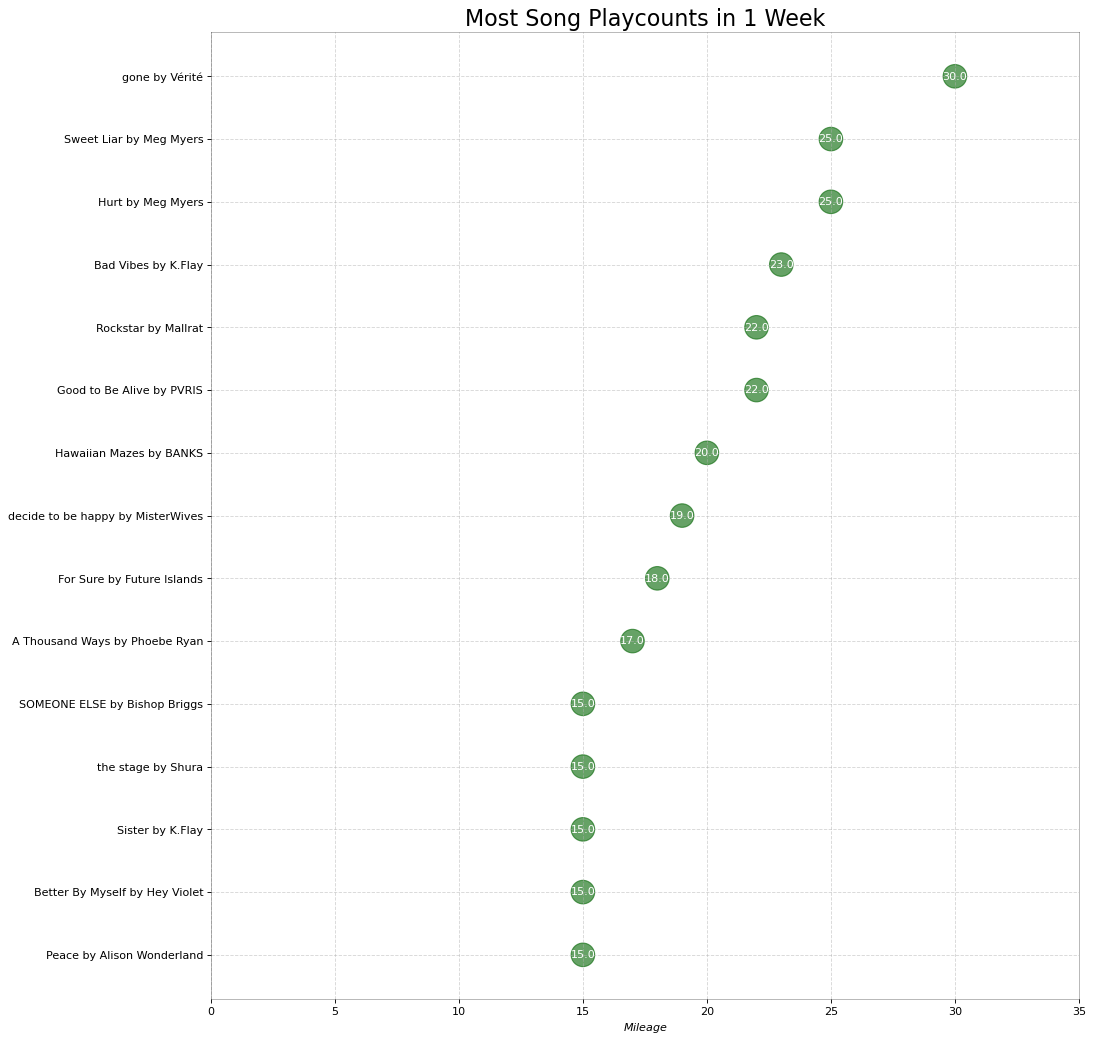

In [56]:
# Prepare Data
df = dat10
x = df.loc[:, ['Playcount']]
df['colors'] = ['red' if x < 0 else 'darkgreen' for x in df['Playcount']]
df.sort_values('Playcount', inplace=True)
df.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(14,16), dpi= 80)
plt.scatter(df.Playcount, df.index, s=450, alpha=.6, color=df.colors)
for x, y, tex in zip(df.Playcount, df.index, df.Playcount):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':'white'})

# Decorations
# Lighten borders
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.yticks(df.index, df.track)
plt.title('Most Song Playcounts in 1 Week', fontdict={'size':20})
plt.xlabel('$Mileage$')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0, 35)
plt.show()

In [57]:
dat10.to_csv('dat10_topinaweek.csv',index=False)
#dat10 = pd.read_csv('dat10_topinaweek.csv')

In [58]:
# Here are my most played tracks over the past 98 weeks
dat9 = dat8.melt(id_vars=['track'], var_name='Week', value_name='Playcount')
dat9['Plays'] = dat9.groupby('track')['Playcount'].transform('sum')
dat9 = dat9.drop('Playcount', axis=1)
dat9 = dat9.drop('Week', axis=1)
idx = dat9.groupby(['track'])['Plays'].transform(max) == dat9['Plays']
dat10 = dat9[idx]
dat10 = dat10[dat10['Plays'] >= 65]
dat10 = dat10.sort_values('Plays',ascending=False)
dat10 = dat10.drop_duplicates()

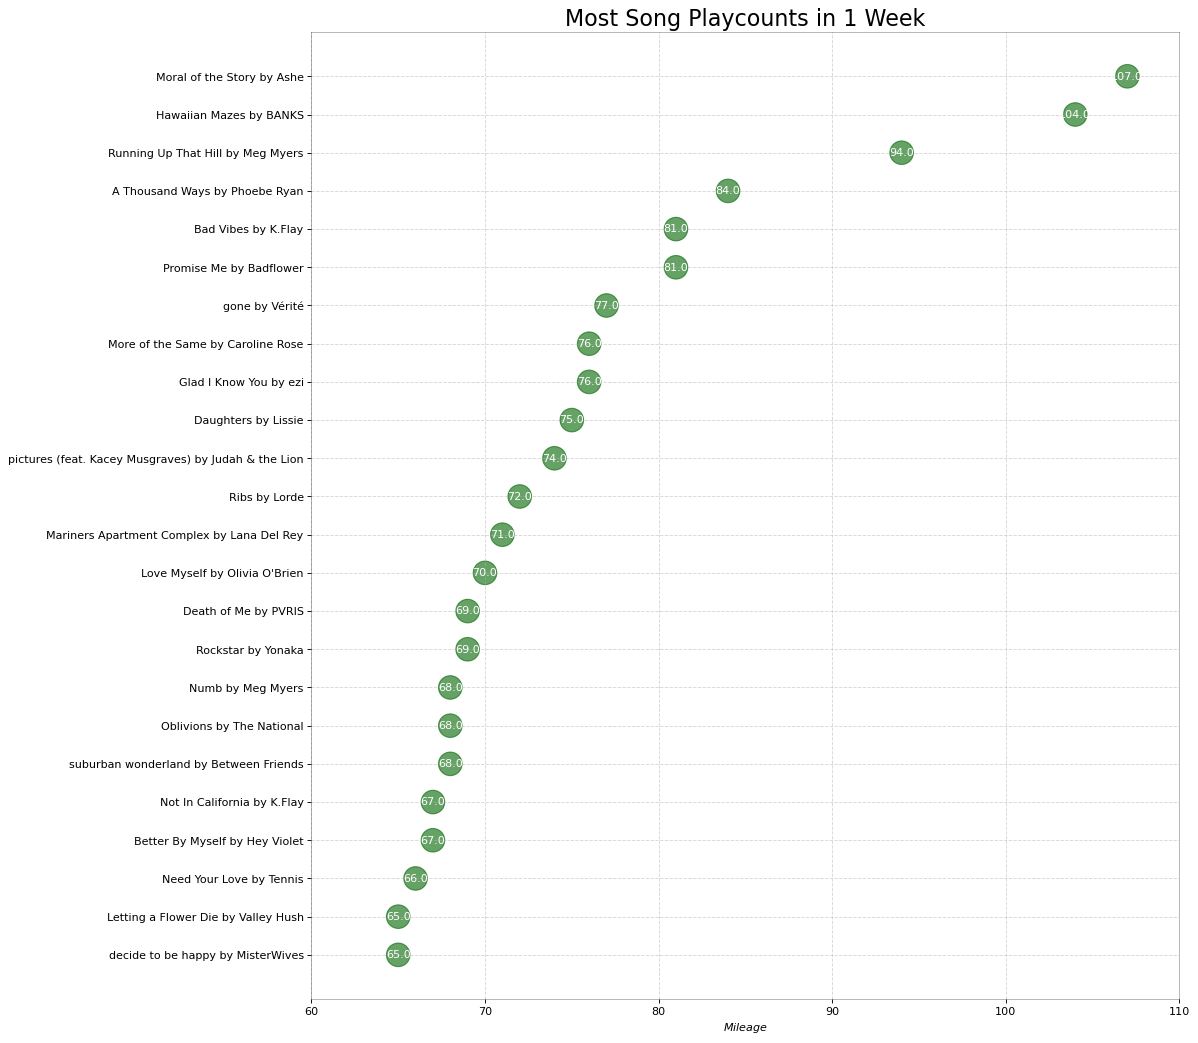

In [59]:
# Prepare Data
df = dat10
x = df.loc[:, ['Plays']]
df['colors'] = ['red' if x < 0 else 'darkgreen' for x in df['Plays']]
df.sort_values('Plays', inplace=True)
df.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(14,16), dpi= 80)
plt.scatter(df.Plays, df.index, s=450, alpha=.6, color=df.colors)
for x, y, tex in zip(df.Plays, df.index, df.Plays):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':'white'})

# Decorations
# Lighten borders
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.yticks(df.index, df.track)
plt.title('Most Song Playcounts in 1 Week', fontdict={'size':20})
plt.xlabel('$Mileage$')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(60, 110)
plt.show()

In [60]:
# Obviously, these are songs that I started playing earlier on since there are more days and opportunities for these songs
# to be played.

In [62]:
dat10.to_csv('dat10_toptotal.csv',index=False)
#dat10 = pd.read_csv('dat11_toptotal.csv')